In [1]:
# Import components
import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from matplotlib import pyplot as pltw
from pmdarima import arima, datasets, model_selection, utils
from scipy import spatial
from scipy.spatial import distance
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import STL

warnings.simplefilter("ignore")

plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
plt.style.use("ggplot")  # グラフのスタイル
plt.rcParams["figure.figsize"] = [12, 9]  # グラフサイズ設定

In [26]:
df = pd.read_csv("../datasets/fixed_battery_log_2_copy.csv")
df["date"] = pd.to_datetime(df["date"])
users = df["User"].unique()
weekdays = df["weekday"].unique()
weekdays.sort()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
p_name = ["A", "B", "C", "D", "E", "F", "G", "H"]
fig.suptitle("四分位除去,T/Q: 30days")

ori, after = 0, 0

for g in range(len(users)):
    n = 30
    user = users[g]
    f_date = dt.datetime.strptime("2021-12-20", "%Y-%m-%d")
    l_date = f_date + dt.timedelta(days=n)

    f2_date = l_date + dt.timedelta(days=1)
    l2_date = f2_date + dt.timedelta(days=n)

    # print(f_date, l_date, f2_date, l2_date)

    Nari_T = pd.DataFrame(
        df.loc[
            (df["User"] == user)
            & (df["state"] == "ON")
            & (df["date"] > f_date)
            & (df["date"] < l_date)
            # & (df["weekday"] == weekday)
        ][["battery", "time_to_num"]].copy()
    )

    hoge = []
    baa = []
    for i in range(0, 24):
        baa = np.array(
            Nari_T.loc[
                (Nari_T["time_to_num"] > 3600 * i)
                & (Nari_T["time_to_num"] < 3600 * (i + 1))
            ]["battery"]
        )
        # print(len(baa), len(baa[np.where((baa >= q1) & (baa <= q3))]))
        # print(baa)
        # print(baa[np.where((baa >= q1) & (baa <= q3))])
        ori += len(baa)
        if len(baa) != 1:
            try:
                q1 = np.percentile(baa, q=25)
                q3 = np.percentile(baa, q=75)
                after += len(baa[np.where((baa >= q1) & (baa <= q3))])
                hoge.append(baa[np.where((baa >= q1) & (baa <= q3))].mean())
            except:
                hoge.append(0)
        else:
            hoge.append(0)
    hoge = np.nan_to_num(hoge)
    # print(hoge)

    Nari_Q = pd.DataFrame(
        df.loc[
            (df["User"] == user)
            & (df["state"] == "ON")
            & (df["date"] > f2_date)
            & (df["date"] < l2_date)
            # & (df["weekday"] == weekday)
        ][["battery", "time_to_num"]].copy()
    )

    foo = []
    baa = []
    for i in range(0, 24):
        baa = np.array(
            Nari_Q.loc[
                (Nari_Q["time_to_num"] > 3600 * i)
                & (Nari_Q["time_to_num"] < 3600 * (i + 1))
            ]["battery"]
        )
        ori += len(baa)
        # print(len(baa), len(baa[np.where((baa >= q1) & (baa <= q3))]))
        if len(baa) != 1:
            try:
                q1 = np.percentile(baa, q=25)
                q3 = np.percentile(baa, q=75)
                after += len(baa[np.where((baa >= q1) & (baa <= q3))])
                foo.append(baa[np.where((baa >= q1) & (baa <= q3))].mean())
            except:
                foo.append(0)
        else:
            foo.append(0)
    foo = np.nan_to_num(foo)
    # print(foo)

    if g < 4:
        axes[0, g].set_title("{}".format(p_name[g]))
        axes[0, g].plot(hoge, "x--r", label="T")
        axes[0, g].plot(foo, "^--b", label="Q")
        axes[0, g].set_xlabel("hours", loc="right")
        axes[0, g].set_ylabel("battery")
        axes[0, g].set_ylim(0, 100)
        axes[0, g].legend()
    else:
        axes[1, (g - 4)].set_title("{}".format(p_name[g]))
        axes[1, (g - 4)].plot(hoge, "x--r", label="T")
        axes[1, (g - 4)].plot(foo, "^--b", label="Q")
        axes[1, (g - 4)].set_ylim(0, 100)
        axes[1, (g - 4)].set_xlabel("hours", loc="right")
        axes[1, (g - 4)].set_ylabel("battery")
        axes[1, (g - 4)].legend()
print(ori)
print(after)
print(after / ori * 100)

In [41]:
n = 30

f_date = dt.datetime.strptime("2021-12-20", "%Y-%m-%d")
l_date = f_date + dt.timedelta(days=n)

f2_date = l_date + dt.timedelta(days=1)
l2_date = f2_date + dt.timedelta(days=n)

# print(f_date, l_date, f2_date, l2_date)

doo = []
daa = []

for day in weekdays:
    Nari_T = pd.DataFrame(
        df.loc[
            (df["User"] == "Narita")
            & (df["state"] == "ON")
            & (df["date"] > f_date)
            & (df["date"] < l_date)
            & (df["weekday"] == day)
        ][["battery", "time_to_num"]].copy()
    )

    hoge = []

    for i in range(0, 12):
        baa = np.array(
            Nari_T.loc[
                (Nari_T["time_to_num"] > 3600 * i)
                & (Nari_T["time_to_num"] < 3600 * (i + 1))
            ]["battery"]
        )
        hoge.append(baa.mean())
    hoge = np.nan_to_num(hoge)
    # print(hoge)
    doo.append(hoge)

    Nari_Q = pd.DataFrame(
        df.loc[
            (df["User"] == "Narita")
            & (df["state"] == "ON")
            & (df["date"] > f2_date)
            & (df["date"] < l2_date)
            & (df["weekday"] == day)
        ][["battery", "time_to_num"]].copy()
    )

    hoge = []

    for i in range(0, 12):
        baa = np.array(
            Nari_Q.loc[
                (Nari_Q["time_to_num"] > 3600 * i)
                & (Nari_Q["time_to_num"] < 3600 * (i + 1))
            ]["battery"]
        )
        hoge.append(baa.mean())
    hoge = np.nan_to_num(hoge)
    # print(hoge)
    daa.append(hoge)

[0 1 2 3 4 5 6]


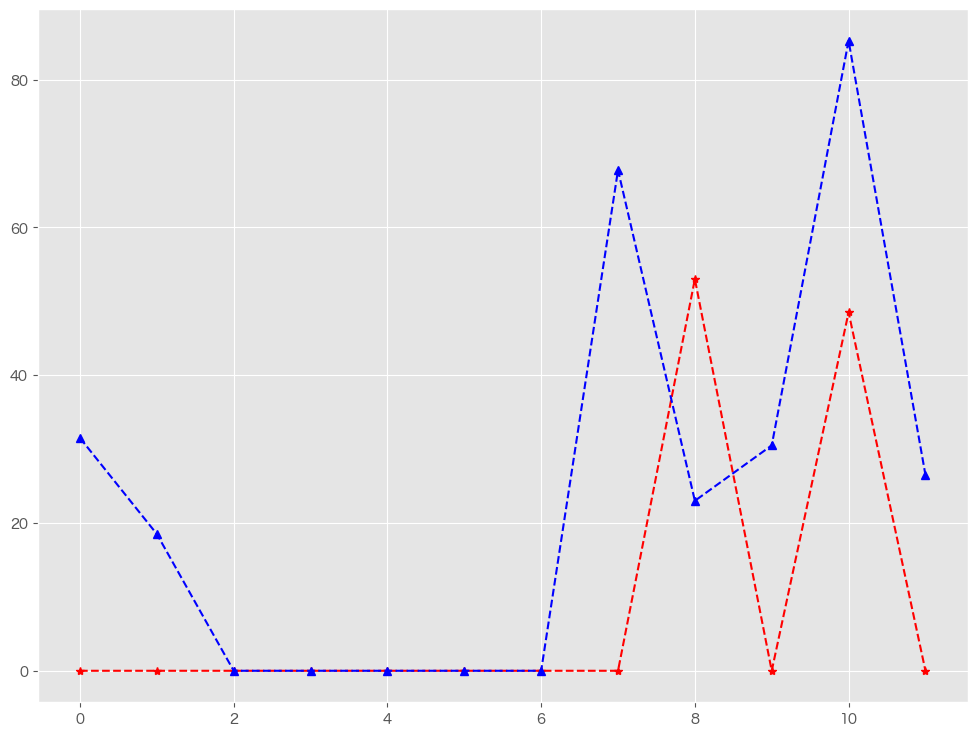

In [50]:
print(weekdays)
plt.plot(doo[1], "r--*")
plt.plot((daa[5] + daa[6]) / 2, "b--^")

In [53]:
print(distance.euclidean(doo[1], (daa[2] + daa[3]) / 2))
print(distance.euclidean(doo[1], (daa[5] + daa[6]) / 2))

67.86429473589186
99.03345394360433


In [54]:
print(distance.euclidean(doo[1], daa[5]))
print(distance.euclidean(doo[1], daa[6]))

104.76759995342071
125.36048021605534


In [59]:
print(distance.cosine(doo[1], daa[5]))
print(distance.cosine(doo[1], daa[6]))
print(distance.cosine(daa[5], daa[6]))

0.32999777930281793
0.5872656636191305
0.3745185219335321


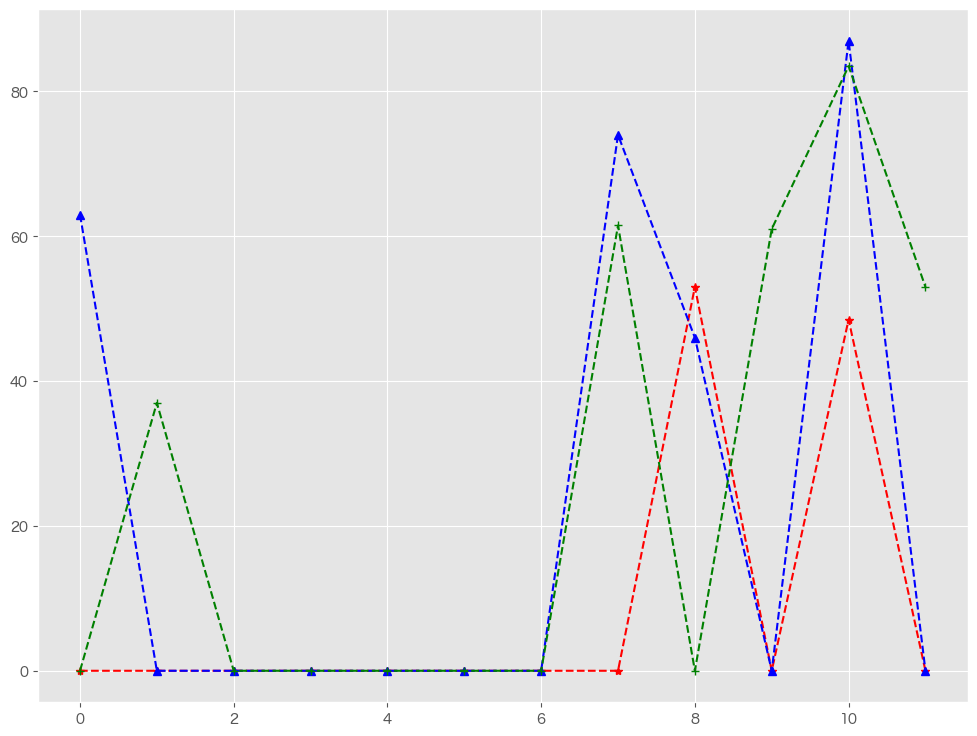

In [57]:
plt.plot(doo[1], "r--*")
plt.plot(daa[5], "b--^")
plt.plot(daa[6], "g--+")

In [ ]:
from scipy import interpolate
